<a href="https://colab.research.google.com/github/VictoriaXinyi/Twitter/blob/main/LDA_5G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade gensim
!pip install pyLDAvis
!pip install contractions

     |████████████████████████████████| 24.1 MB 73.0 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=602339cf3643ad70393147e8c58bbed69e5322ff0202a0373c7f864e6da971c0
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
     |████████████████████████████████| 287 kB 5.0 MB/s 
     |████████████████████████████████| 106 kB 53.7 MB/s 


In [26]:
from google.colab import drive  # to mount Google Drive to Colab notebook
#import tweepy                   # Python wrapper around Twitter API
import json, csv, re, os, string, nltk, spacy, gensim, requests, time
import contractions
import pandas as pd
from datetime import date
from datetime import datetime
import numpy as np
from numpy import array
from collections import Counter
from operator import itemgetter
from pprint import pprint

# Nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("words") 
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer,TweetTokenizer
stopwords = set(stopwords.words("english"))

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

# Gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
drive.mount('/content/gdrive')
path = './gdrive/My Drive'

Mounted at /content/gdrive


In [27]:
df=pd.read_csv('gdrive/My Drive/twitter_data/df1.csv')

In [5]:
# size of df
count_row = df.shape[0]  # Gives number of rows
count_col = df.shape[1]  # Gives number of columns
print(count_row)
print(count_col)

23141
29


In [6]:
df.head(3)

,created_at,lang,text,id,author_id,geo.place_id,geo.name,geo.country_code,geo.country,geo.id,...,author.username,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.tweet_count,author.public_metrics.listed_count,author.id,author.name,author.location,geo.coordinates.type,geo.coordinates.coordinates
0,2021-04-29T23:39:55.000Z,en,Customers are loving this 5G for All Trade in ...,1387914576784592896,992609029326176257,0fc3474d6915b000,T-Mobile,US,Etats-Unis,0fc3474d6915b000,...,elMartinMoore,360,477,621,0,992609029326176257,Martin Moore,NaN,NaN,NaN
1,2021-04-29T23:33:03.000Z,en,These 5G speeds are crazy! @TMobile #WeWontSto...,1387912847909220352,66944716,3b77caf94bfc81fe,Los Angeles,US,Etats-Unis,3b77caf94bfc81fe,...,BPalomoTMO,137,959,125,2,66944716,Berny Palomo,"Los Angeles, CA",NaN,NaN
2,2021-04-29T23:02:52.000Z,en,This reads very strangely because it’s an inco...,1387905252066832384,18609072,91eb113282d003a1,Lansing,US,Etats-Unis,91eb113282d003a1,...,JPughMI,5377,2684,15426,143,18609072,Joshua Pugh,No more than 6 miles from a body of water,NaN,NaN


In [28]:
# create my df
mydf = df[["text"]]
mydf.head(1)

,text
0,Customers are loving this 5G for All Trade in ...


In [29]:
# 处理文本 make a duplicate
mydata =mydf.copy()

In [30]:
# =============================== data preparation ================================== #

# remove emoji, set contract
mydata['text'] = mydata['text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
mydata['no_contract'] = mydata['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
mydata['text_str'] = [' '.join(map(str, l)) for l in mydata['no_contract']]
mydata.head(2)

<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<ipython-input-30-c2cd667ce92f>:4: DeprecationWarning: invalid escape sequence \w
  mydata['text'] = mydata['text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,text,no_contract,text_str
0,Customers are loving this 5G for All Trade in ...,"[Customers, are, loving, this, 5G, for, All, T...",Customers are loving this 5G for All Trade in ...
1,These 5G speeds are crazy @TMobile #WeWontStop...,"[These, 5G, speeds, are, crazy, @TMobile, #WeW...",These 5G speeds are crazy @TMobile #WeWontStop...


In [34]:
def remove_links(tweet):
    '''Takes a string and removes web links'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    tweet = re.sub(r'\d+', '', tweet) #removes the digits
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    # tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove hashtag
    return tweet

# stopwords
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['5G','5g']) # 大小写要核实下后面的调试顺序，先加上
# punctuation
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#'
# stem the words in the list
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem


# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    #tweet = re.sub('([0,1,2,3,4,6,7,8,9]+)', '', tweet) # remove numbers, except "5"
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
   
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in stop_words] # remove stopwords
    tweet_token_list = [word_rooter(word) if '#' not in word else word 
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

<input>:31: DeprecationWarning: invalid escape sequence \s
<input>:31: DeprecationWarning: invalid escape sequence \s
<input>:31: DeprecationWarning: invalid escape sequence \s
<input>:31: DeprecationWarning: invalid escape sequence \s
<input>:31: DeprecationWarning: invalid escape sequence \s
<input>:31: DeprecationWarning: invalid escape sequence \s
<input>:31: DeprecationWarning: invalid escape sequence \s
<input>:31: DeprecationWarning: invalid escape sequence \s
<input>:31: DeprecationWarning: invalid escape sequence \s
<ipython-input-34-aa8e31798713>:31: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('\s+', ' ', tweet) #remove double spacing


In [35]:
# Tokenize and Clean-up using gensim’s simple_preprocess()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [36]:
data_words = list(sent_to_words(mydata.text_str))
mydata['clean_tweet'] = mydata.text_str.apply(clean_tweet)
mydata.head(2)

,text,no_contract,text_str,clean_tweet
0,Customers are loving this 5G for All Trade in ...,"[Customers, are, loving, this, 5G, for, All, T...",Customers are loving this 5G for All Trade in ...,custom love g trade promo see vintag devic bea...
1,These 5G speeds are crazy @TMobile #WeWontStop...,"[These, 5G, speeds, are, crazy, @TMobile, #WeW...",These 5G speeds are crazy @TMobile #WeWontStop...,g speed crazi


In [37]:
newdata = mydata.copy()
newdata = mydata[["text",'clean_tweet']]
newdata.head(3)

,text,clean_tweet
0,Customers are loving this 5G for All Trade in ...,custom love g trade promo see vintag devic bea...
1,These 5G speeds are crazy @TMobile #WeWontStop...,g speed crazi
2,This reads very strangely because its an incom...,read strang incomplet pictur event protest non...


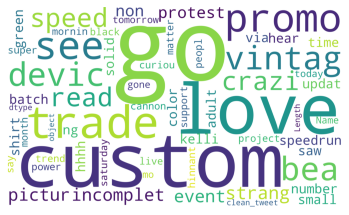

In [61]:
wordcloud = WordCloud(background_color="white",width=5000, height=3000, margin=2).generate(str(newdata.clean_tweet))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#wordcloud.to_file('test.png')

In [40]:
# Remove Stopwords, Form Bigrams, Trigrams and Lemmatization
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    ## Remove numbers, but not words that contain numbers.
    texts_out = [[word for word in simple_preprocess(str(doc)) if not word.isdigit()] for doc in texts_out]   
    ## Remove words that are only one character.
    texts_out = [[word for word in simple_preprocess(str(doc)) if len(word) > 3] for doc in texts_out]
    return texts_out
data_ready = process_words(data_words)

print(data_ready[:3])

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interf

[['custom', 'love', 'trade', 'promo'], ['speed'], ['event', 'protest', 'nonexist', 'vaccin', 'passport', 'full', 'anti', 'vaccin', 'complet']]


In [38]:
## Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
data_words = list(sent_to_words(newdata.clean_tweet))

In [39]:
print(data_words[:3])

[['custom', 'love', 'trade', 'promo', 'see', 'vintag', 'devic', 'beach', 'amp', 'talbert'], ['speed', 'crazi'], ['read', 'strang', 'incomplet', 'pictur', 'event', 'protest', 'nonexist', 'vaccin', 'passport', 'full', 'anti', 'vaccin', 'crank', 'ralli', 'complet', 'speaker', 'rail', 'smart', 'meter']]


In [63]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
#dictionary.filter_extremes(no_below=10, no_above=0.2) #filter out tokens

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
# View:the produced corpus shown above is a mapping of (word_id, word_frequency).
print(corpus[:1])
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

[[(0, 1), (1, 1), (2, 1), (3, 1)]]
Number of unique tokens: 6558
Number of documents: 23141


In [29]:
## set a base model
num_topics = 5
chunksize = 100 
passes = 10 
iterations = 100
eval_every = 1  

# Make a index to word dictionary.
#temp = dictionary[0]  # only to "load" the dictionary.
#id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus,id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())

[(0,
  '0.056*"protest" + 0.042*"come" + 0.040*"would" + 0.028*"check" + '
  '0.027*"video" + 0.026*"happen" + 0.023*"year" + 0.015*"listen" + '
  '0.014*"alway" + 0.014*"offic"'),
 (1,
  '0.061*"live" + 0.046*"matter" + 0.045*"support" + 0.044*"time" + '
  '0.026*"shoot" + 0.025*"racism" + 0.023*"polic" + 0.023*"think" + '
  '0.021*"thing" + 0.020*"keep"'),
 (2,
  '0.115*"black" + 0.042*"peopl" + 0.033*"soul" + 0.028*"today" + 0.027*"stop" '
  '+ 0.026*"still" + 0.024*"need" + 0.023*"know" + 0.022*"love" + '
  '0.020*"want"'),
 (3,
  '0.036*"take" + 0.034*"plea" + 0.033*"good" + 0.032*"vote" + 0.031*"justic" '
  '+ 0.024*"fight" + 0.022*"even" + 0.019*"give" + 0.017*"sign" + '
  '0.016*"share"'),
 (4,
  '0.045*"make" + 0.037*"thank" + 0.028*"kill" + 0.028*"back" + 0.027*"murder" '
  '+ 0.024*"work" + 0.022*"right" + 0.021*"stand" + 0.020*"white" + '
  '0.019*"watch"')]


In [31]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -6.221084948970153


In [1]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,
               iterations=20,alpha='auto',eta='auto',eval_every = None,
               passes=50,
               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
# check Coherence
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=5, limit=30, step=1)

NameError: ignored

In [36]:
# 测试coherence
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,
               iterations=20,alpha='auto',eta='auto',eval_every = None,
               passes=50,
               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
# check Coherence
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=5, limit=61, step=3)

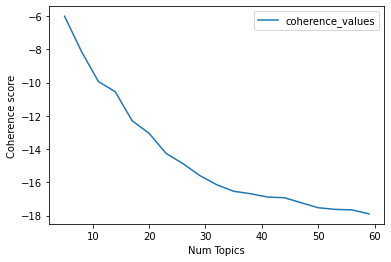

In [38]:
# Show graph - 35 topics
limit=61; start=5; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["coherence_values"], loc='best')
plt.show()

In [43]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,
               iterations=20,alpha='auto',eta='auto',eval_every = None,
               passes=50,
               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
# check Coherence
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=20, limit=201, step=5)


In [ ]:
#gdsfgdyafkgrhdsfhdfhjgfkafghdgsfjhgdsfkfaghgfhd

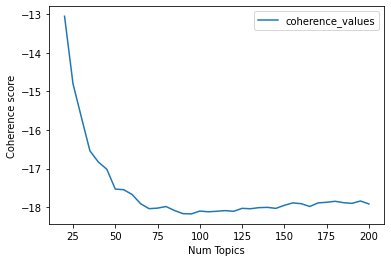

In [44]:
# Show graph - 50 topics
limit=201; start=20; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["coherence_values"], loc='best')
plt.show()

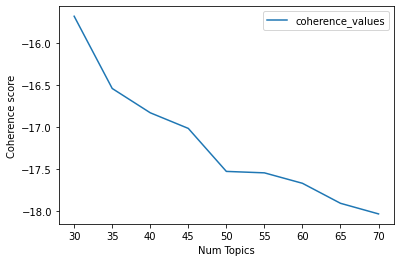

In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=30, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,
               iterations=20,alpha='auto',eta='auto',eval_every = None,
               passes=50,
               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
# check Coherence
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=30, limit=71, step=5)
# Show graph - 35 topics? 50 topics?
limit=71; start=30; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["coherence_values"], loc='best')
plt.show()

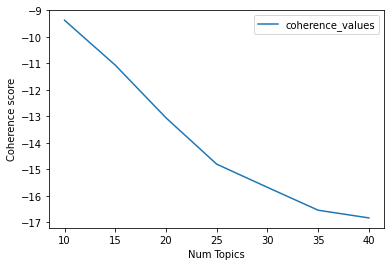

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,
               iterations=20,alpha='auto',eta='auto',eval_every = None,
               passes=50,
               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
# check Coherence
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=10, limit=41, step=5)
# Show graph - 25 or 35 topics
limit=41; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["coherence_values"], loc='best')
plt.show()

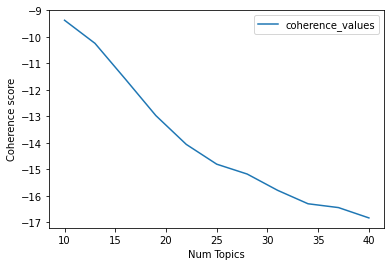

In [49]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,
               iterations=20,alpha='auto',eta='auto',eval_every = None,
               passes=50,
               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
# check Coherence
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=10, limit=41, step=3)
# Show graph - 22 or 25 topics
limit=41; start=10; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["coherence_values"], loc='best')
plt.show()

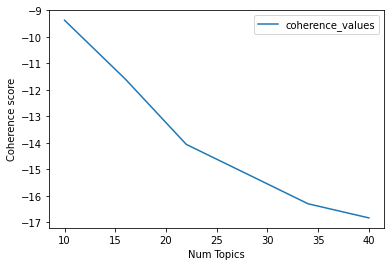

In [50]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=6):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,
               iterations=20,alpha='auto',eta='auto',eval_every = None,
               passes=50,
               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
# check Coherence
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=10, limit=41, step=6)
# Show graph - 22 topics
limit=41; start=10; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["coherence_values"], loc='best')
plt.show()

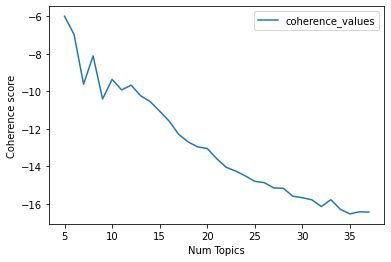

In [52]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,
               iterations=20,alpha='auto',eta='auto',eval_every = None,
               passes=50,
               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
# check Coherence
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=5, limit=38, step=1)
# Show graph - 50 topics
limit=38; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["coherence_values"], loc='best')
plt.show()

In [60]:
print (coherence_values)

[-6.0060143903075485, -6.977495154949278, -9.626070681485666, -8.120537402547619, -10.41523484732306, -9.370476977451604, -9.93216482147821, -9.678814547039652, -10.242307058535497, -10.552336718340202, -11.06474697506397, -11.594491239283624, -12.298561804347656, -12.705590645138129, -12.968484312680728, -13.053354876526777, -13.598374013553485, -14.05579653087841, -14.257559731234096, -14.513184667566774, -14.802514083849232, -14.87495089801852, -15.157333463362736, -15.17444258144447, -15.596094799640461, -15.677066801844584, -15.788796219951507, -16.14678278165652, -15.782138175785903, -16.296414068672153, -16.540112788036044, -16.429099001794576, -16.440459734541395]


In [15]:
# --------- final LDA = 7 topics ----------- #
# good coherence scores (range[-14,+14]) ,but may have repeated keywords in the topic, gonna check pyLDAvis
# option 7,9,11

# test K=7
num_topics = 7
lda_model_7 = LdaModel(corpus=corpus, id2word=id2word, num_topics = num_topics, random_state=100,
               iterations=20,alpha='auto',eta='auto',
               passes=50,
               per_word_topics=True) 

pyLDAvis.enable_notebook()
p_7 = gensimvis.prepare(lda_model_7, corpus, id2word)
p_7

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.429817  0.051502       1        1  36.276943
4      0.018135 -0.410395       2        1  15.549454
5      0.093324  0.079142       3        1  10.770130
6      0.077528  0.114397       4        1  10.593882
1      0.086444  0.061968       5        1  10.133679
3      0.075466  0.055589       6        1   8.589394
0      0.078921  0.047797       7        1   8.086518, topic_info=          Term         Freq        Total Category  logprob  loglift
1005     black  2348.000000  2348.000000  Default  30.0000  30.0000
705       live  1018.000000  1018.000000  Default  29.0000  29.0000
59       would   734.000000   734.000000  Default  28.0000  28.0000
345      thank   725.000000   725.000000  Default  27.0000  27.0000
167       make   921.000000   921.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
661      repre    55.464841    56.257343   Topic7  -5.0202   2.5008
158       sale    54.853167    55.644722   Topic7  -5.0313   2.5006
517     situat    54.655670    55.448101   Topic7  -5.0349   2.5006
271   interest    54.249066    55.040525   Topic7  -5.0424   2.5005
408      dream    52.356489    53.148795   Topic7  -5.0779   2.5000

[240 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
700       5  0.988870   account
407       4  0.992848    action
457       3  0.994843     allow
380       2  0.998112     alway
181       4  0.984307  american
...     ...       ...       ...
39        1  0.998167      work
59        6  0.998263     would
159       6  0.987773     write
65        1  0.999122      year
1555      3  0.989640     young

[210 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 6, 7, 2, 4, 1])

In [57]:
# test K=9
num_topics = 9
lda_model_9 = LdaModel(corpus=corpus, id2word=id2word, num_topics = num_topics, random_state=100,
               iterations=20,alpha='auto',eta='auto',
               passes=50,
               per_word_topics=True) 

pyLDAvis.enable_notebook()
p_9 = gensimvis.prepare(lda_model_9, corpus, id2word)
p_9

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.220039  0.373492       1        1  22.678182
6     -0.322659 -0.278571       2        1  19.895320
2     -0.079360 -0.011704       3        1  19.655948
1      0.100983 -0.016107       4        1   9.330896
5      0.106296 -0.014760       5        1   6.997042
0      0.106901 -0.014470       6        1   6.528564
7      0.101501 -0.012994       7        1   5.755338
3      0.103252 -0.012610       8        1   4.606105
8      0.103126 -0.012276       9        1   4.552606, topic_info=           Term         Freq        Total Category  logprob  loglift
1005      black  2408.000000  2408.000000  Default  30.0000  30.0000
345       thank   717.000000   717.000000  Default  29.0000  29.0000
59        would   736.000000   736.000000  Default  28.0000  28.0000
251       peopl  1135.000000  1135.000000  Default  27.0000  27.0000
705        live  1044.000000  1044.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1227     repost    29.945478    30.789102   Topic9  -5.0621   3.0617
765       ahead    29.676559    30.520230   Topic9  -5.0711   3.0614
2184    quickli    29.449280    30.293390   Topic9  -5.0788   3.0612
3394      scene    28.576032    29.419634   Topic9  -5.1089   3.0604
827   everywher    27.497092    28.340740   Topic9  -5.1474   3.0593

[301 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
341       8  0.982133    access
700       4  0.994112   account
407       2  0.995804    action
765       9  0.982955     ahead
457       4  0.995783     allow
...     ...       ...       ...
264       6  0.997126     world
59        7  0.998850     would
65        1  0.998923      year
1053      7  0.972049  year_old
1555      6  0.995616     young

[272 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 3, 2, 6, 1, 8, 4, 9])

In [58]:
# test K=11
num_topics = 11
lda_model_11 = LdaModel(corpus=corpus, id2word=id2word, num_topics = num_topics, random_state=100,
               iterations=20,alpha='auto',eta='auto',
               passes=50,
               per_word_topics=True) 

pyLDAvis.enable_notebook()
p_11 = gensimvis.prepare(lda_model_11, corpus, id2word)
p_11

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.428722 -0.094215       1        1  15.178722
4      0.042804  0.436722       2        1  13.901482
6     -0.003809 -0.016056       3        1  11.835686
2     -0.020570 -0.016517       4        1  11.194539
1     -0.073646 -0.057841       5        1  11.130993
9     -0.020920 -0.016509       6        1  10.456557
5     -0.071770 -0.049245       7        1   7.419297
7     -0.077828 -0.052513       8        1   5.959802
3     -0.070920 -0.047102       9        1   4.935635
10    -0.067724 -0.044618      10        1   4.014613
8     -0.064338 -0.042108      11        1   3.972675, topic_info=           Term         Freq        Total Category  logprob  loglift
1005      black  2439.000000  2439.000000  Default  30.0000  30.0000
251       peopl  1211.000000  1211.000000  Default  29.0000  29.0000
345       thank   752.000000   752.000000  Default  28.0000  28.0000
59        would   764.000000   764.000000  Default  27.0000  27.0000
705        live  1058.000000  1058.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1227     repost    31.394189    32.280596  Topic11  -4.8786   3.1979
827   everywher    28.825661    29.712071  Topic11  -4.9639   3.1954
1954     trauma    28.237450    29.123878  Topic11  -4.9845   3.1948
570       quick    26.105525    26.991945  Topic11  -5.0630   3.1923
5003    paralyz    26.096163    26.982597  Topic11  -5.0634   3.1923

[360 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
341       9  0.991767     access
700       6  0.994871    account
407       4  0.994747     action
3723      9  0.982499   activist
272       1  0.993923     actual
...     ...       ...        ...
59        9  0.999450      would
482       6  0.995640      wrong
65        1  0.998402       year
189       6  0.989672  yesterday
1555      3  0.990476      young

[330 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 7, 3, 2, 10, 6, 8, 4, 11, 9])

In [ ]:
"""
# hyperparameters tests - tuning
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):   
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=k, 
                        random_state=100,
                        chunksize=100,
                        passes=50,
                        alpha=a,
                        eta=b)    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')    
    return coherence_model_lda.get_coherence()


import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 10
max_topics = 40
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=2000)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()
"""

In [16]:
# What is the Dominant topic and its percentage contribution in each document?

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_7, corpus=corpus, texts=data_ready)
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,2.0,0.2468,"peopl, time, today, need, stop, take, matter, ...","[custom, love, trade, promo]"
1,2.0,0.3235,"peopl, time, today, need, stop, take, matter, ...",[speed]
2,2.0,0.3479,"peopl, time, today, need, stop, take, matter, ...","[event, protest, nonexist, vaccin, passport, f..."
3,0.0,0.3432,"video, find, full, offic, fuck, plan, folk, de...","[speedrun, time, batch, number, hhhh]"
4,2.0,0.3235,"peopl, time, today, need, stop, take, matter, ...",[hear]
...,...,...,...,...
23136,2.0,0.3258,"peopl, time, today, need, stop, take, matter, ...","[small, green, adult, shirt]"
23137,2.0,0.3538,"peopl, time, today, need, stop, take, matter, ...","[solid, project, power]"
23138,2.0,0.3609,"peopl, time, today, need, stop, take, matter, ...",[]
23139,4.0,0.4240,"make, support, protest, stand, fight, give, vo...","[support, name, ride, bike]"


In [18]:
# Format df_topic_sents_keywords
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic','Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.2468,"peopl, time, today, need, stop, take, matter, ...","[custom, love, trade, promo]"
1,1,2.0,0.3235,"peopl, time, today, need, stop, take, matter, ...",[speed]
2,2,2.0,0.3479,"peopl, time, today, need, stop, take, matter, ...","[event, protest, nonexist, vaccin, passport, f..."
3,3,0.0,0.3432,"video, find, full, offic, fuck, plan, folk, de...","[speedrun, time, batch, number, hhhh]"
4,4,2.0,0.3235,"peopl, time, today, need, stop, take, matter, ...",[hear]
...,...,...,...,...,...
23136,23136,2.0,0.3258,"peopl, time, today, need, stop, take, matter, ...","[small, green, adult, shirt]"
23137,23137,2.0,0.3538,"peopl, time, today, need, stop, take, matter, ...","[solid, project, power]"
23138,23138,2.0,0.3609,"peopl, time, today, need, stop, take, matter, ...",[]
23139,23139,4.0,0.4240,"make, support, protest, stand, fight, give, vo...","[support, name, ride, bike]"


In [19]:
# Find the most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6497,"video, find, full, offic, fuck, plan, folk, de...","[blacklivesmatt, blacklivesmatt, blacklivesmat..."
1,1.0,0.5748,"come, good, feel, child, order, state, human, ...","[know, noodl, good, tast, good, good, planet, ..."
2,2.0,0.7181,"peopl, time, today, need, stop, take, matter, ...","[peopl, talk, gradiat, kill, actual, kill, peo..."
3,3.0,0.5257,"would, thank, keep, first, tonight, movement, ...","[listen, would, thank, first, would, thank, fi..."
4,4.0,0.5504,"make, support, protest, stand, fight, give, vo...","[phone, deal, want, phone, phone, support, tec..."
5,5.0,0.5042,"watch, proud, hear, speak, soul, nation, night...","[line, approx, carb, protein, frost, browni, a..."
6,6.0,0.6977,"black, live, love, white, player, enough, raci...","[black, live, latino, black, live, latino, bla..."


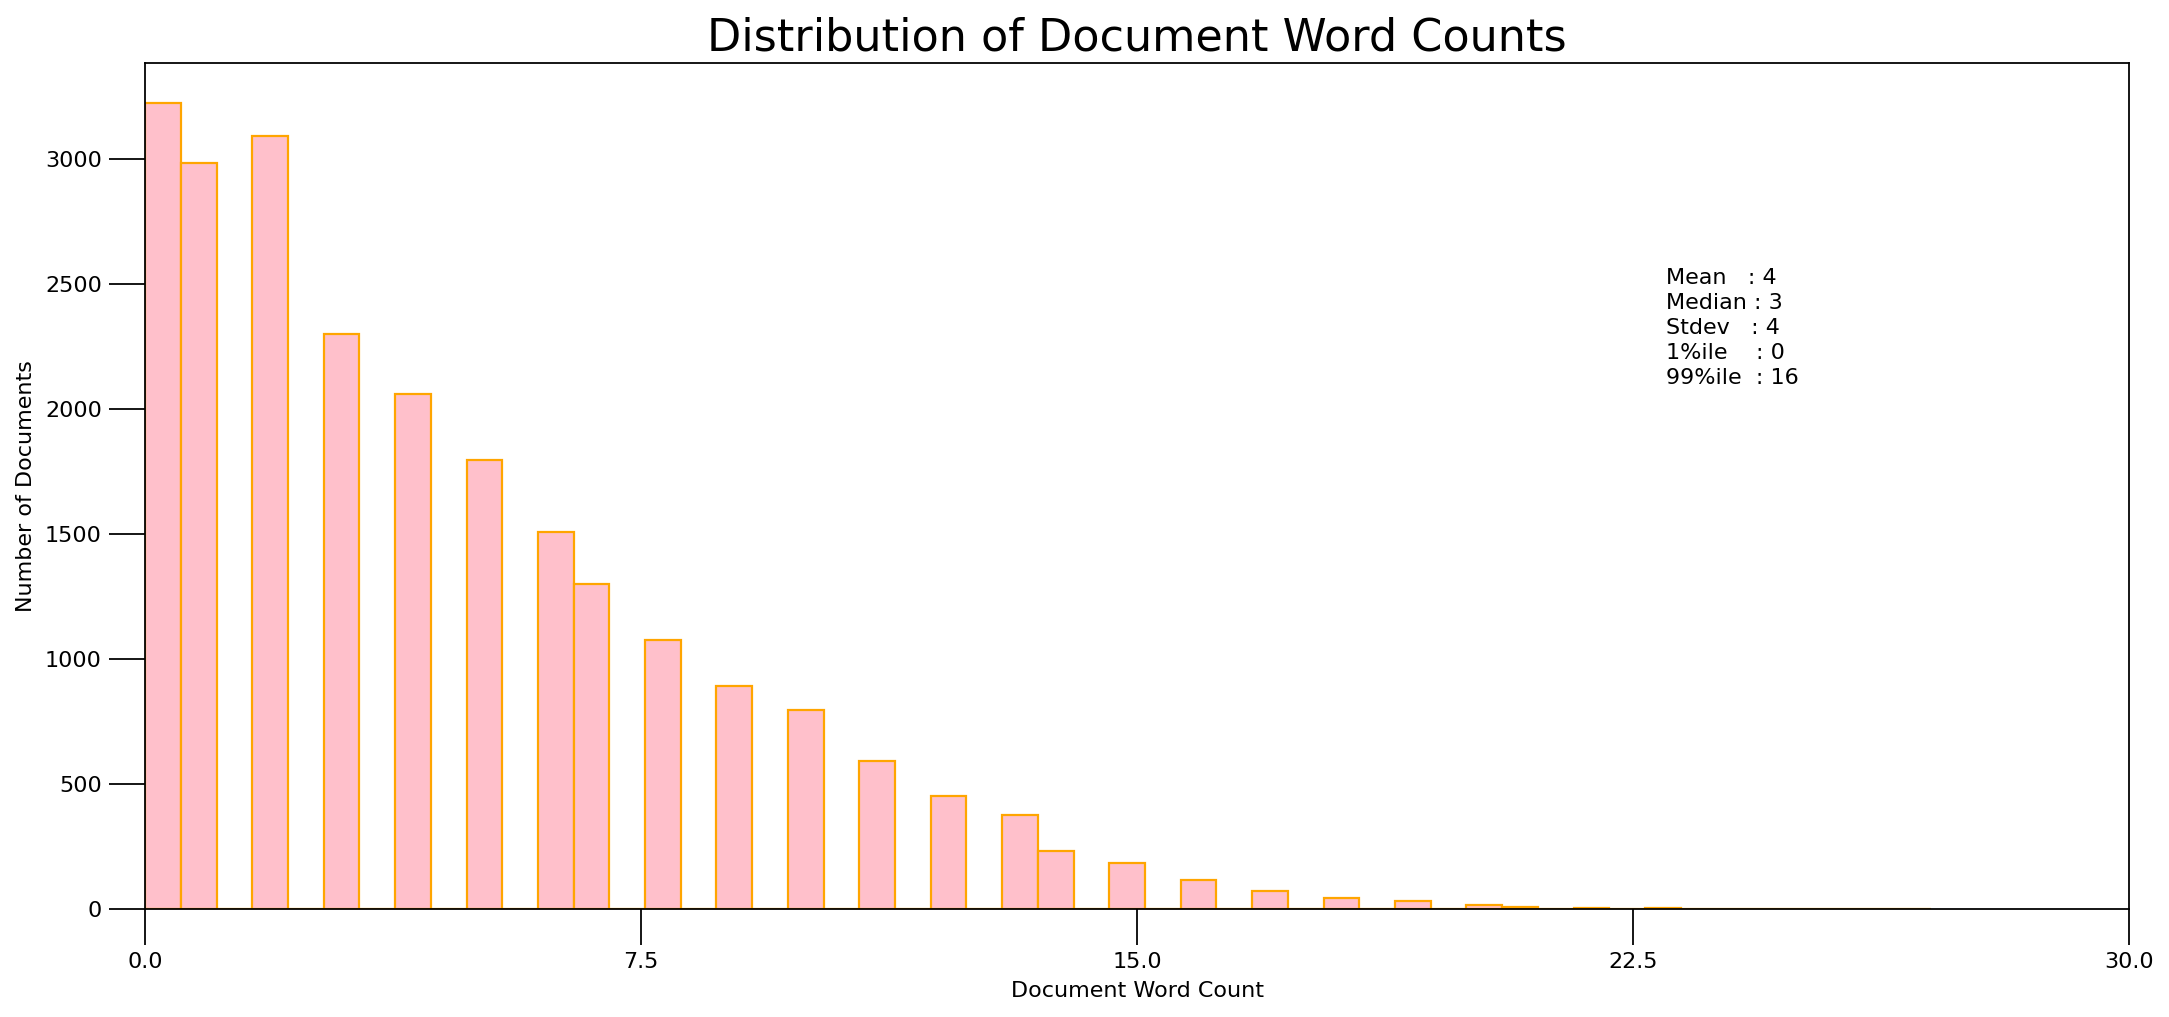

In [74]:
# Frequency Distribution of Word Counts in Documents
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 50, color='pink', ec="orange")
plt.text(23, 2500, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(23, 2400, "Median : " + str(round(np.median(doc_lens))))
plt.text(23, 2300, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(23, 2200, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(23, 2100, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 30), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,30,5))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=20))
plt.show()

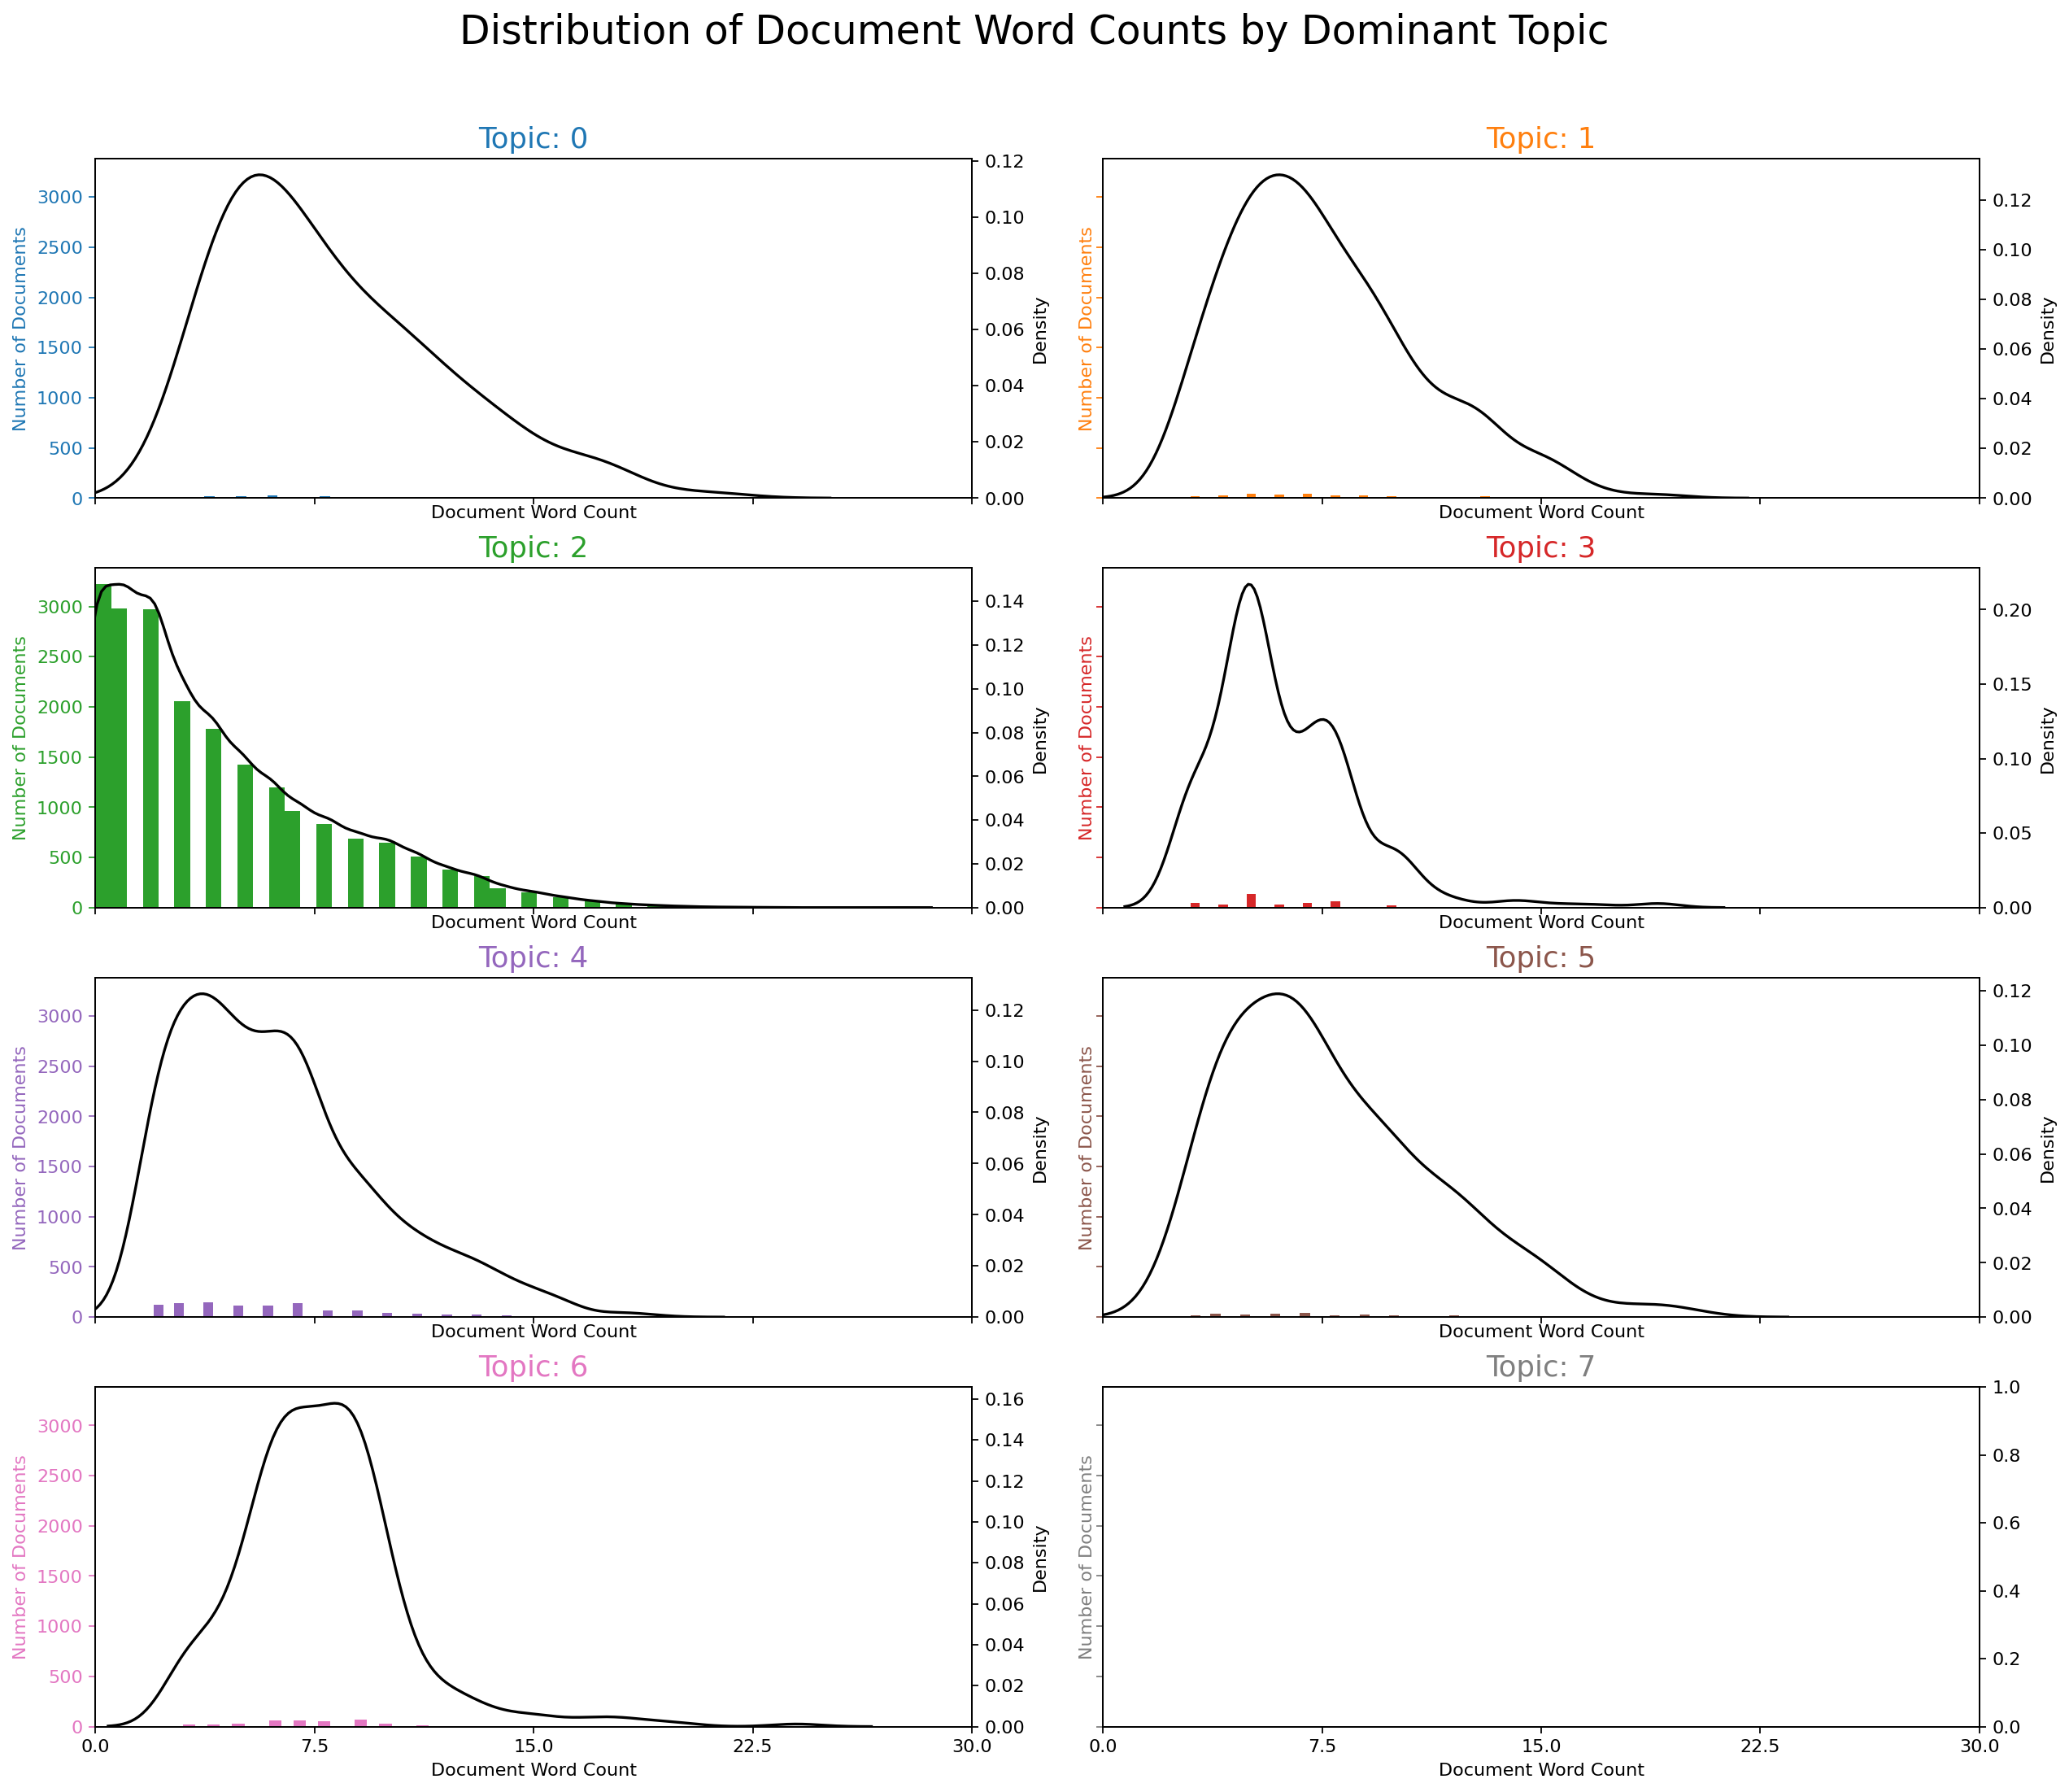

In [22]:
# overview of how big the documents are as a whole and by topic
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(4,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 50, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,30,5))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

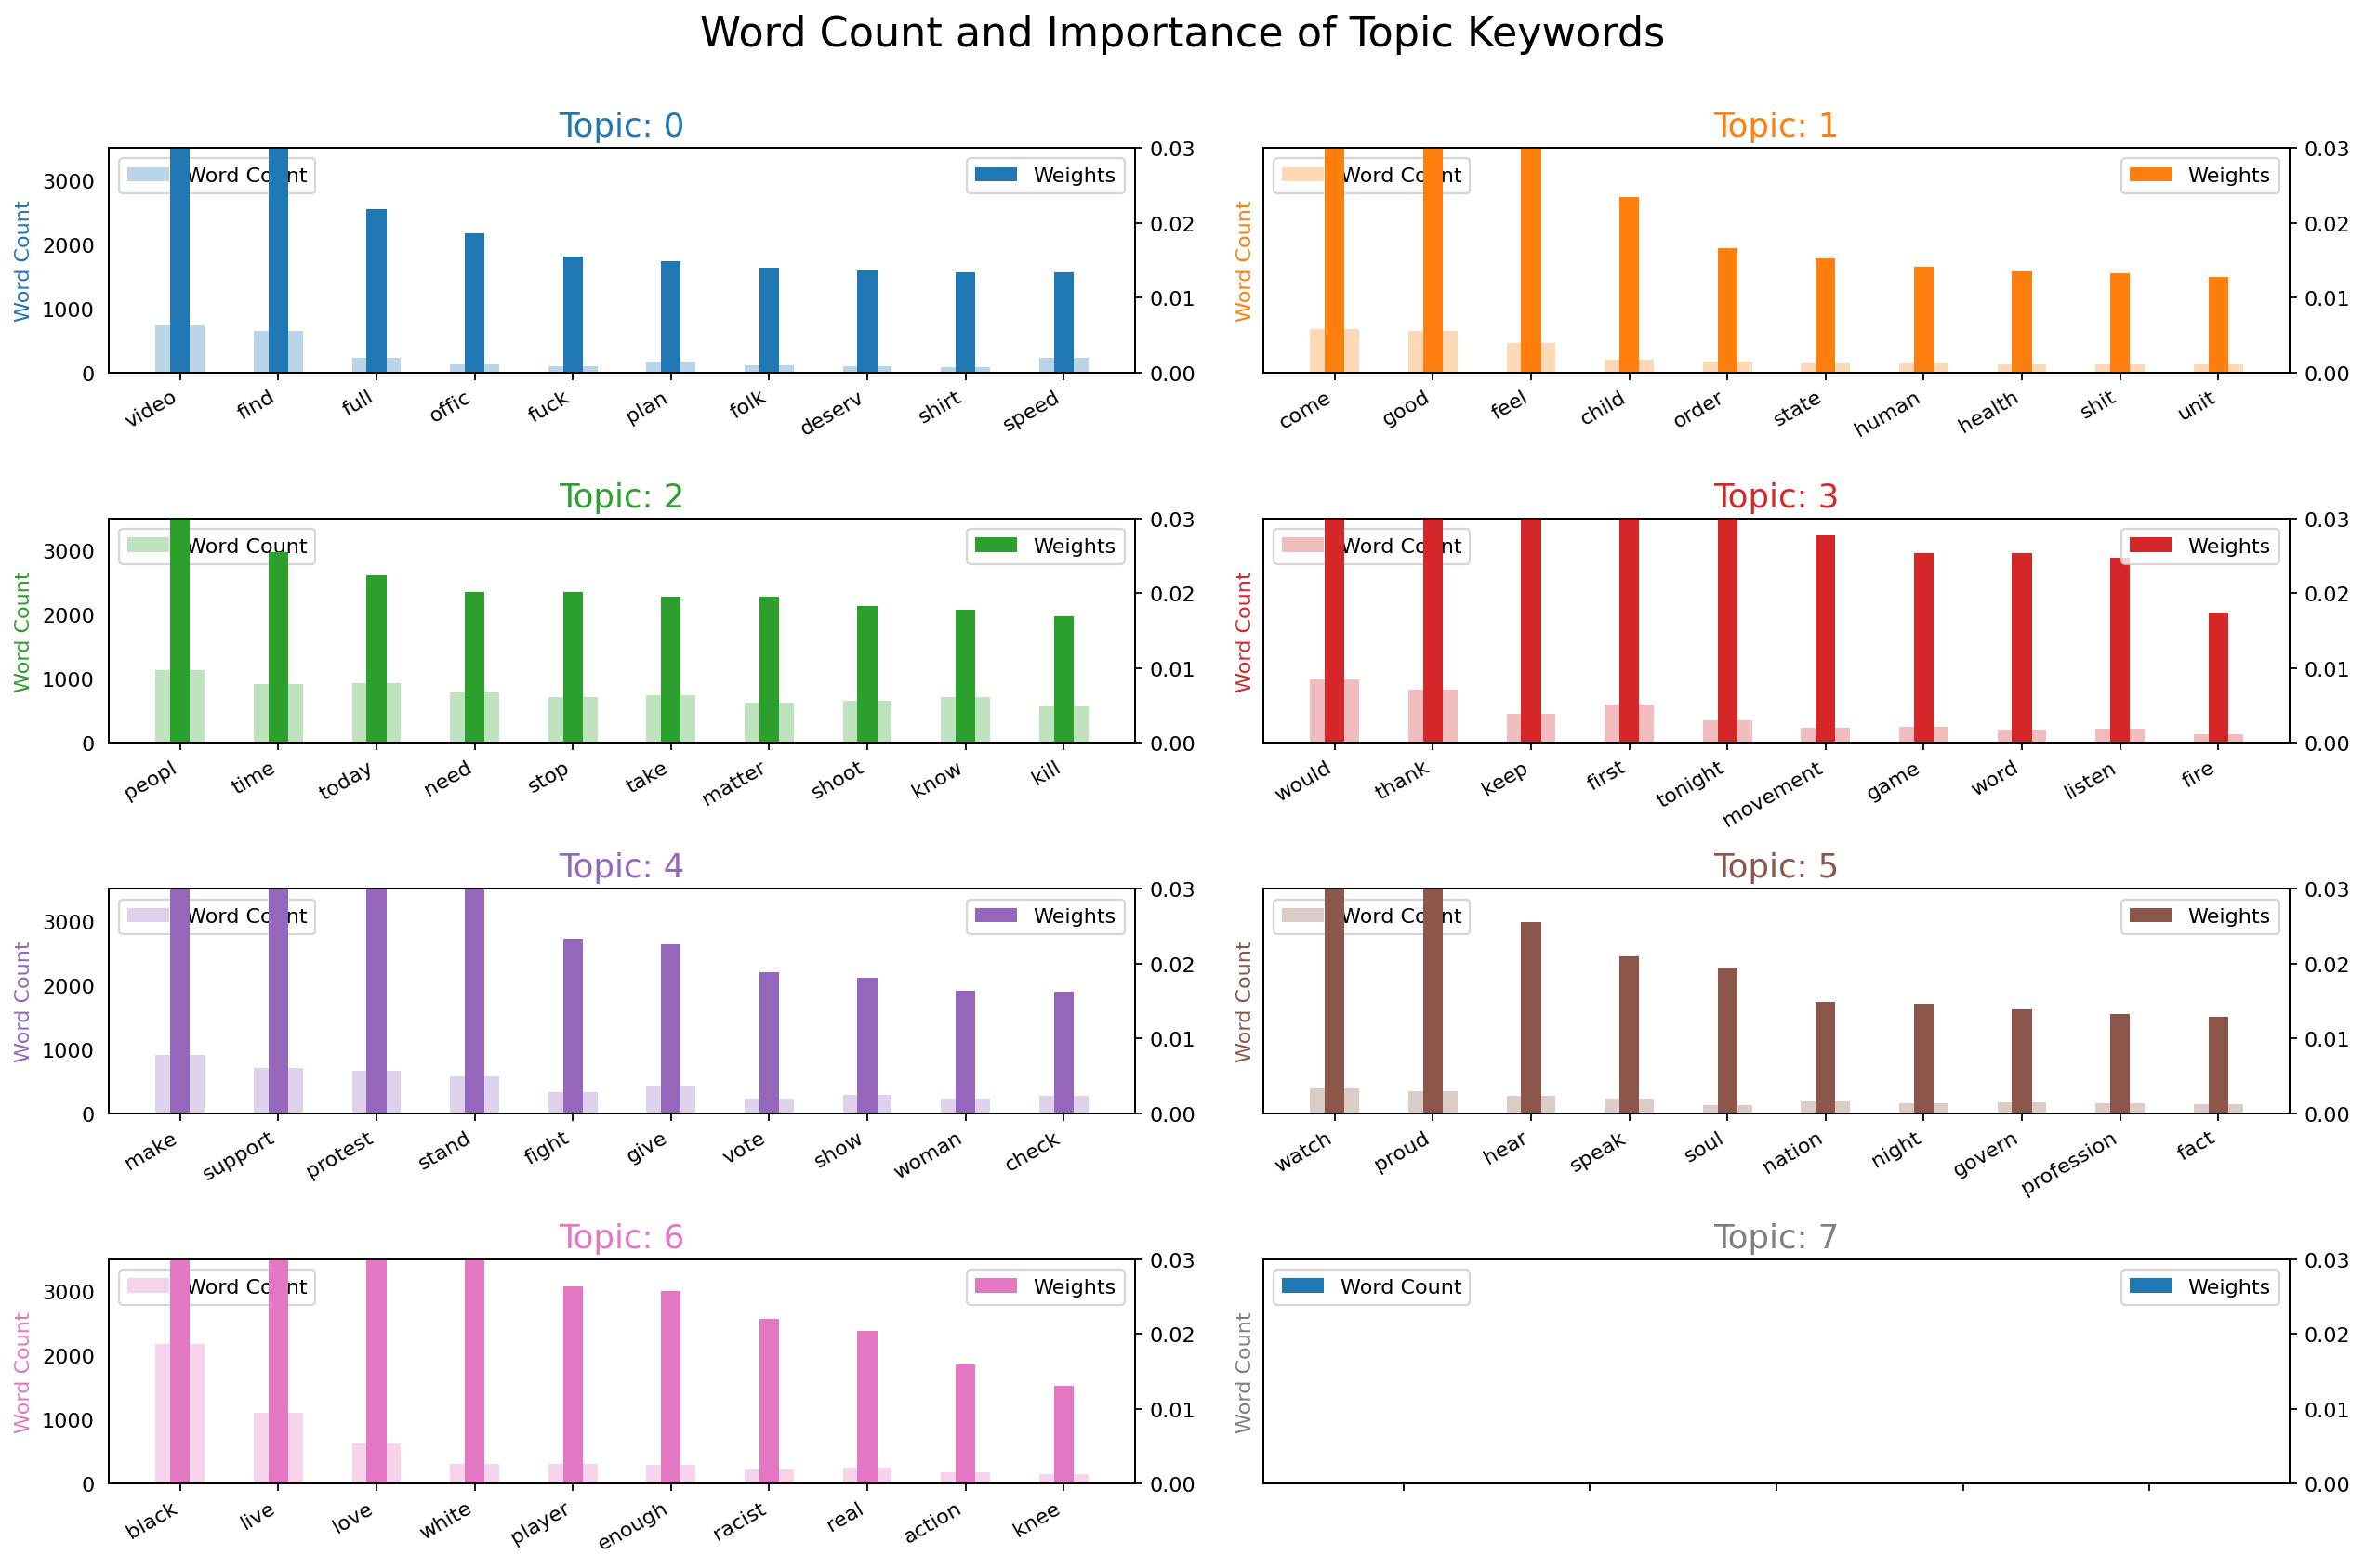

In [23]:
# Word Counts of Topic Keywords
"""
How frequently the words have appeared in the documents?
keep an eye out on the words that occur in multiple topics and the ones 
whose relative frequency is more than the weight. Often such words turn out to 
be less important. 
Solution: add to stopwords , re-run the training process.
"""
from collections import Counter
topics = lda_model_7.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=20, y=1.05)    
plt.show()


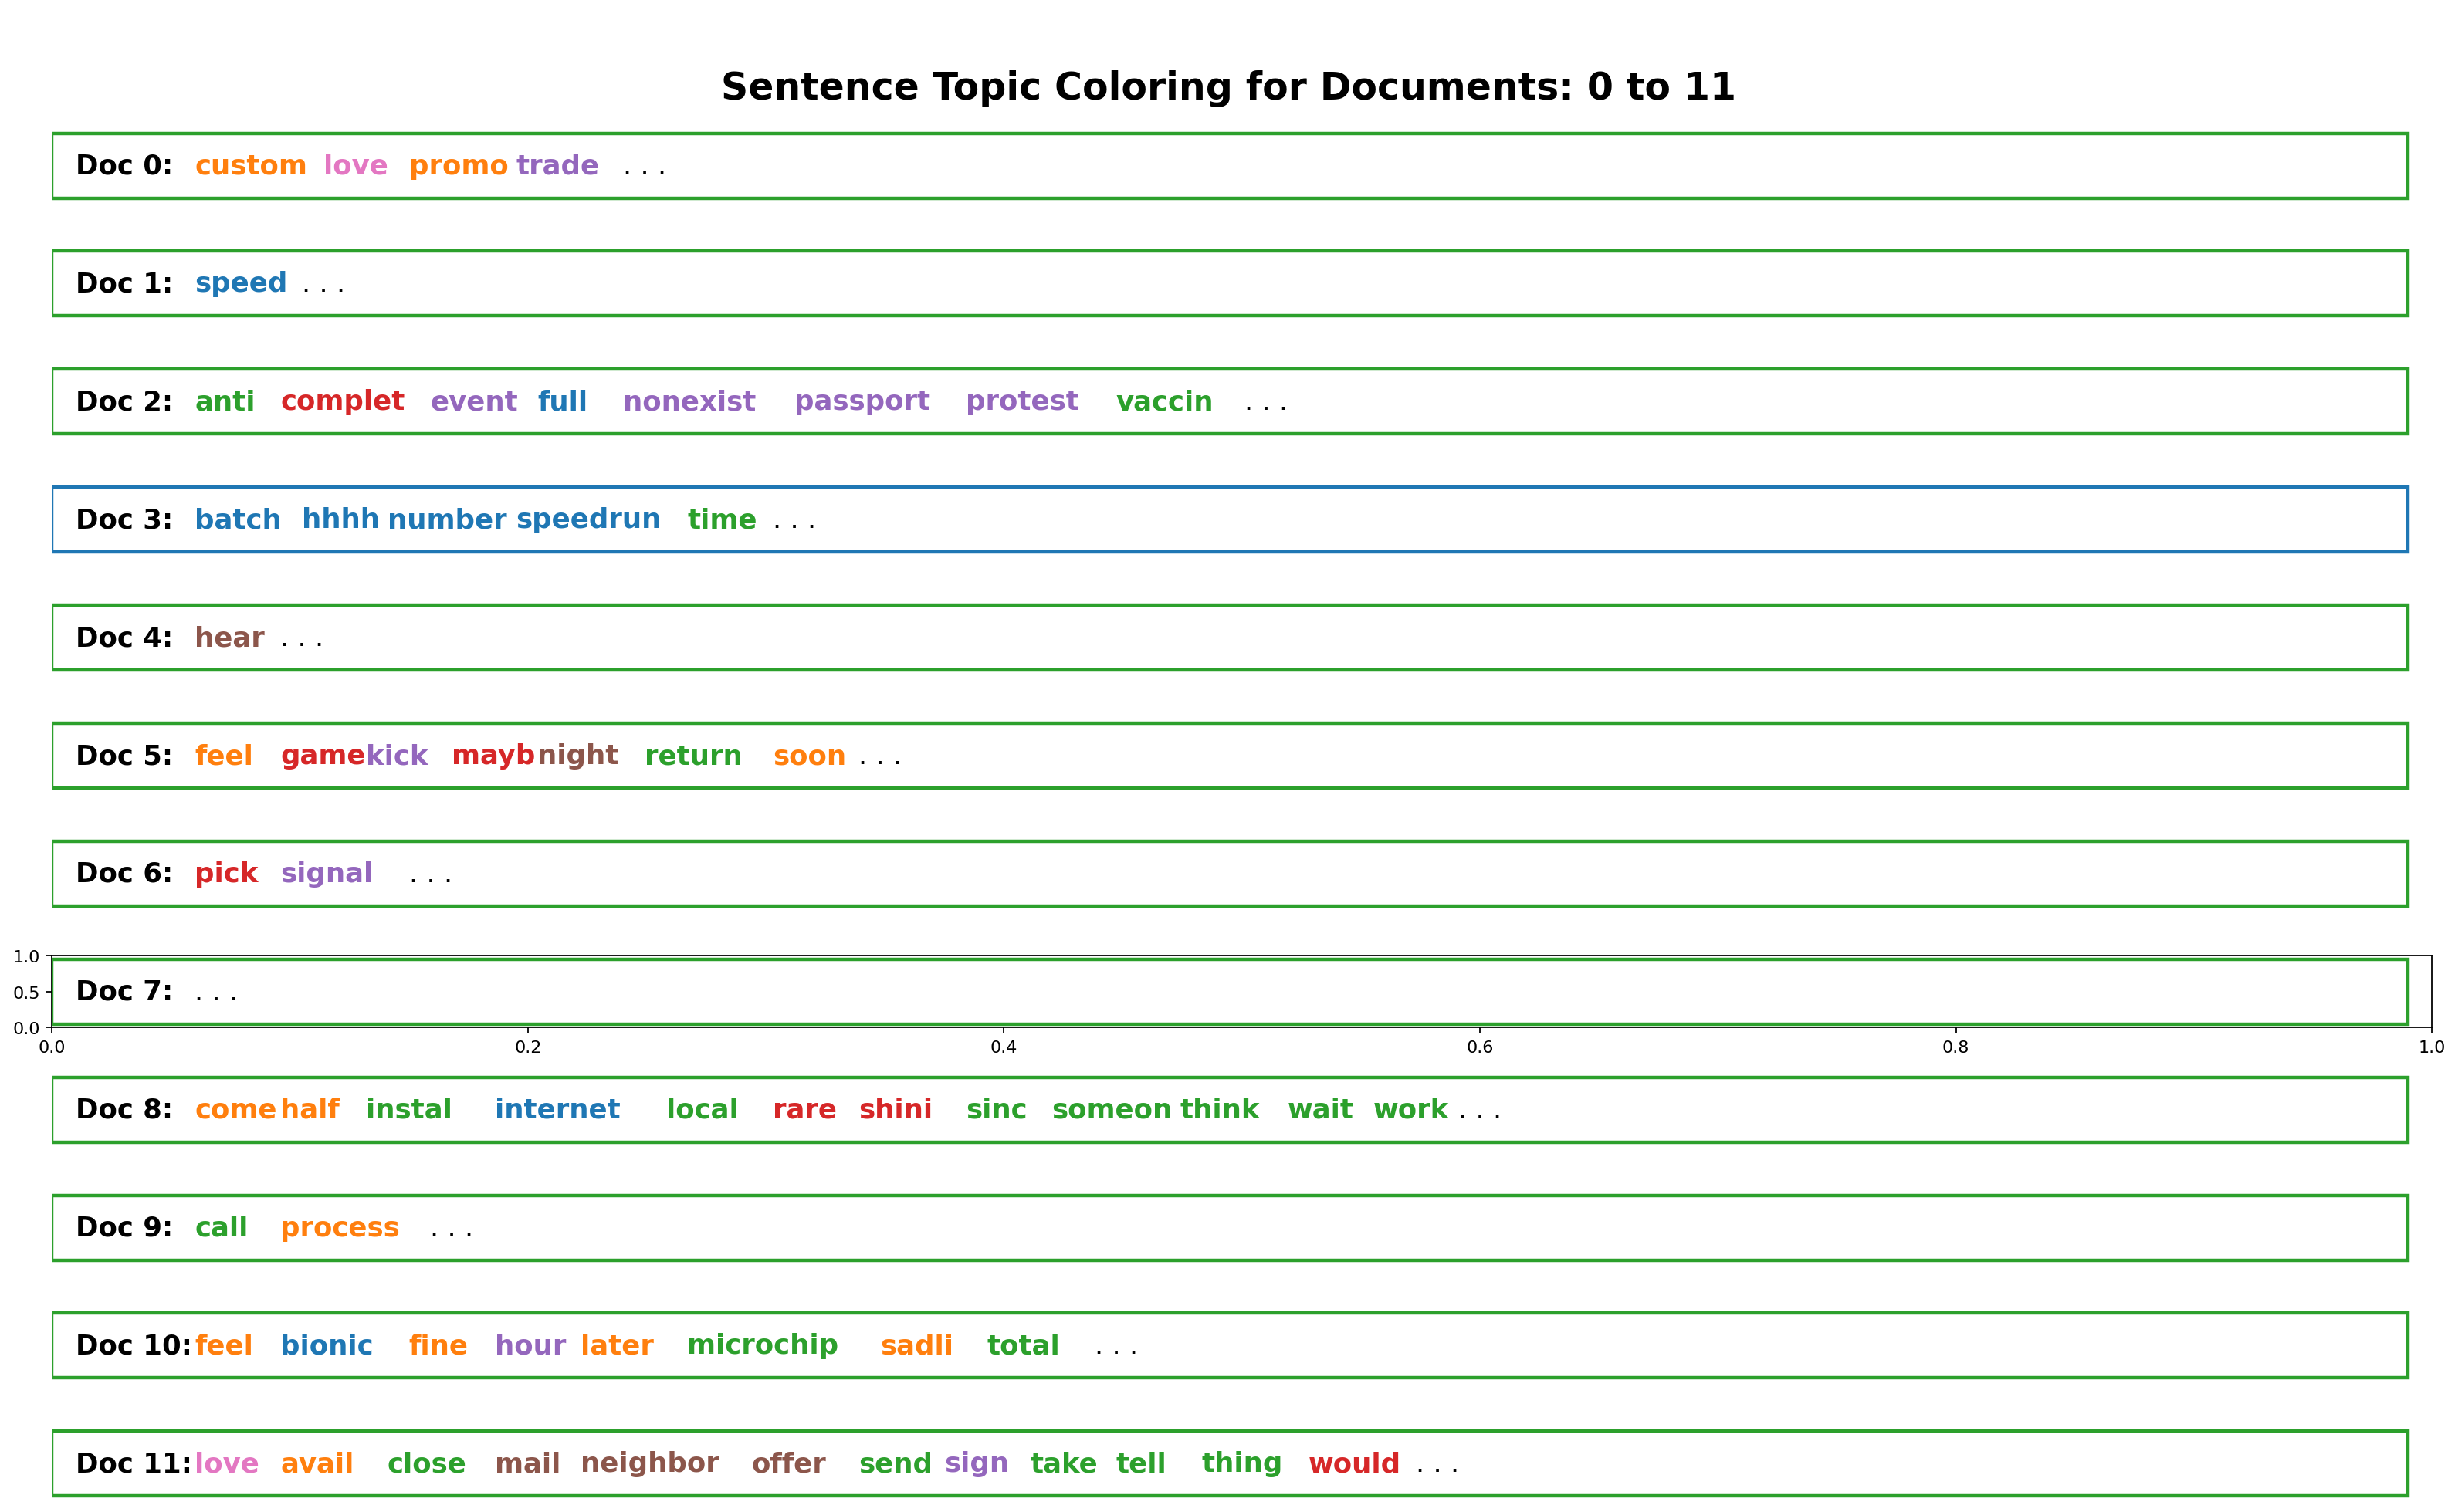

In [24]:
#Sentence Chart Colored by Topic
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model_7, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [27]:
# What are the most discussed topics in the documents?
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model_7, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model_7.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

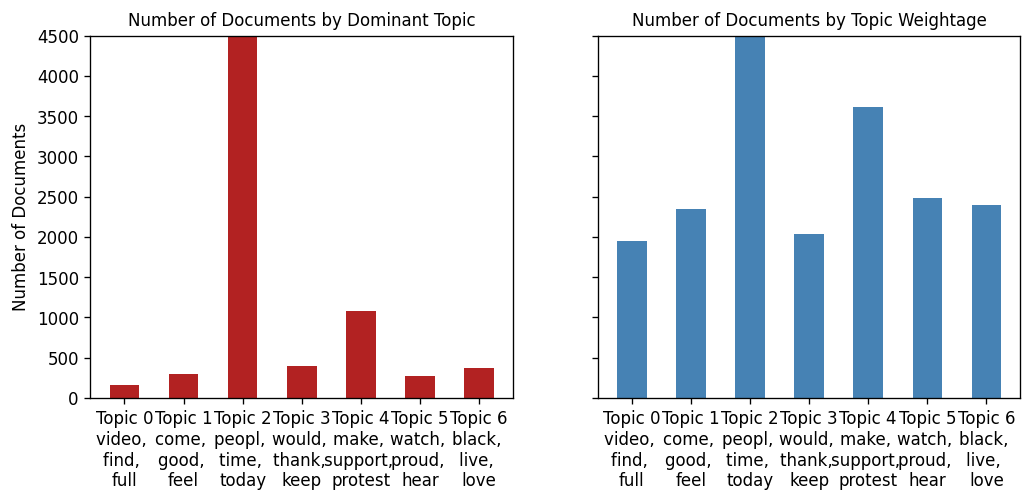

In [31]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 4500)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [35]:
# t-SNE Clustering Chart
# Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model_7[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 7
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
#show(plot)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13717 samples in 0.013s...
[t-SNE] Computed neighbors for 13717 samples in 0.766s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13717
[t-SNE] Computed conditional probabilities for sample 2000 / 13717
[t-SNE] Computed conditional probabilities for sample 3000 / 13717
[t-SNE] Computed conditional probabilities for sample 4000 / 13717
[t-SNE] Computed conditional probabilities for sample 5000 / 13717
[t-SNE] Computed conditional probabilities for sample 6000 / 13717
[t-SNE] Computed conditional probabilities for sample 7000 / 13717
[t-SNE] Computed conditional probabilities for sample 8000 / 13717
[t-SNE] Computed conditional probabilities for sample 9000 / 13717
[t-SNE] Computed conditional probabilities for sample 10000 / 13717
[t-SNE] Computed conditional probabilities for sample 11000 / 13717
[t-SNE] Computed conditional probabilities for sample 12000 / 13717
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.202759
[t-SNE] KL divergence after 1000 iterations: 0.769942


GlyphRenderer(id='1186', ...)

In [36]:
show(plot)

In [37]:
d1=newdata.join(df_dominant_topic, how="outer")
d1.head(2)

,text,clean_tweet,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,Customers are loving this 5G for All Trade in ...,custom love g trade promo see vintag devic bea...,0,2.0,0.2468,"peopl, time, today, need, stop, take, matter, ...","[custom, love, trade, promo]"
1,These 5G speeds are crazy @TMobile #WeWontStop...,g speed crazi,1,2.0,0.3235,"peopl, time, today, need, stop, take, matter, ...",[speed]


In [48]:
testdata = d1.drop(['Document_No','Topic_Perc_Contrib','Keywords','Text'],axis=1)
testdata["text"] = testdata["text"].str.lower()
testdata.head(2)

,text,clean_tweet,Dominant_Topic
0,customers are loving this 5g for all trade in ...,custom love g trade promo see vintag devic bea...,2.0
1,these 5g speeds are crazy @tmobile #wewontstop...,g speed crazi,2.0


In [49]:
def find_hashtags(text):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', text)   

testdata['Hashtags'] = testdata.text.apply(find_hashtags)
testdata.head(2)

,text,clean_tweet,Dominant_Topic,Hashtags
0,customers are loving this 5g for all trade in ...,custom love g trade promo see vintag devic bea...,2.0,[]
1,these 5g speeds are crazy @tmobile #wewontstop...,g speed crazi,2.0,"[#wewontstop, #iphone12promax]"


In [ ]:
## ----------------- hashtag correlation under LDA ----------------- ##

In [51]:
# keep hashtag that appear top 10 #20
from collections import Counter

counts = testdata.Hashtags.map(Counter).sum().most_common(20)
top_hashtags = [ht for ht, _ in counts]
hashtags = testdata.Hashtags.map(set)
base_cols = ['Dominant_Topic', 'Hashtags']
matrix = pd.concat(
             [testdata[base_cols]] +
             [
                 hashtags.map(lambda hts: ht in hts).astype(int)
                 for ht in top_hashtags
             ],
             axis='columns'
         )
matrix.columns = base_cols + top_hashtags
# drop the hashtags column
hashtag_5g= matrix.drop('Hashtags', axis=1)
hashtag_5g.head(3)

,Dominant_Topic,#blacklivesmatter,#blm,#jacobblake,#verizon5gaccess,#sweepstakes,#oscars,#galaxys21,#tmobiletuesdays,#useek,...,#defundthepolice,#breonnataylor,#nojusticenopeace,#blackisking,#covid19,#justiceforbreonnataylor,#kenosha,#montmartre,#glasgow,#marchonwashington
0,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
hashtag_5g.to_csv('gdrive/My Drive/hashtag_5g.csv')
print(len(hashtag_5g))

23141


In [ ]:
#hashtag_5g=pd.read_csv('gdrive/My Drive/hashtag_5g.csv')

In [53]:
hashtag_5g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23141 entries, 0 to 23140
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Dominant_Topic            23141 non-null  float64
 1   #blacklivesmatter         23141 non-null  int64  
 2   #blm                      23141 non-null  int64  
 3   #jacobblake               23141 non-null  int64  
 4   #verizon5gaccess          23141 non-null  int64  
 5   #sweepstakes              23141 non-null  int64  
 6   #oscars                   23141 non-null  int64  
 7   #galaxys21                23141 non-null  int64  
 8   #tmobiletuesdays          23141 non-null  int64  
 9   #useek                    23141 non-null  int64  
 10  #justiceforjacobblake     23141 non-null  int64  
 11  #defundthepolice          23141 non-null  int64  
 12  #breonnataylor            23141 non-null  int64  
 13  #nojusticenopeace         23141 non-null  int64  
 14  #black

In [57]:
indexNames = hashtag_5g[   
    (hashtag_5g['#blacklivesmatter'] == 0) &     
    (hashtag_5g['#blm'] == 0) &
    (hashtag_5g['#jacobblake'] == 0) &
    (hashtag_5g['#verizon5gaccess'] == 0) &
    (hashtag_5g['#sweepstakes'] == 0) &
    (hashtag_5g['#oscars'] == 0) &
    (hashtag_5g['#galaxys21'] == 0) &
    (hashtag_5g['#tmobiletuesdays'] == 0) &
    (hashtag_5g['#useek'] == 0) &
    (hashtag_5g['#justiceforjacobblake'] == 0) &
    (hashtag_5g['#defundthepolice'] == 0) &
    (hashtag_5g['#breonnataylor'] == 0) &
    (hashtag_5g['#nojusticenopeace'] == 0) &
    (hashtag_5g['#blackisking'] == 0) &
    (hashtag_5g['#covid19'] == 0) &
    (hashtag_5g['#justiceforbreonnataylor'] == 0) &
    (hashtag_5g['#kenosha'] == 0) &
    (hashtag_5g['#montmartre'] == 0) &
    (hashtag_5g['#glasgow'] == 0) &
    (hashtag_5g['#marchonwashington'] == 0)
    ].index
matrix=hashtag_5g.drop(indexNames , inplace=True)
matrix=hashtag_5g.copy()

In [59]:
matrix.head(2)

,Dominant_Topic,#blacklivesmatter,#blm,#jacobblake,#verizon5gaccess,#sweepstakes,#oscars,#galaxys21,#tmobiletuesdays,#useek,...,#defundthepolice,#breonnataylor,#nojusticenopeace,#blackisking,#covid19,#justiceforbreonnataylor,#kenosha,#montmartre,#glasgow,#marchonwashington
30,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
49,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [66]:
cor_matrix=matrix.drop(['Dominant_Topic'], axis=1)
#cor_matrix.corr()
cor_matrix.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  This is separate from the ipykernel package so we can avoid doing imports until


,#blacklivesmatter,#blm,#jacobblake,#verizon5gaccess,#sweepstakes,#oscars,#galaxys21,#tmobiletuesdays,#useek,#justiceforjacobblake,#defundthepolice,#breonnataylor,#nojusticenopeace,#blackisking,#covid19,#justiceforbreonnataylor,#kenosha,#montmartre,#glasgow,#marchonwashington
#blacklivesmatter,1.00,0.07,0.06,-0.70,-0.70,-0.67,-0.64,-0.63,-0.62,0.04,0.04,0.04,0.03,0.03,-0.07,0.03,0.03,0.03,0.03,0.03
#blm,0.07,1.00,0.02,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,0.01,0.02,0.03,0.06,-0.02,-0.01,0.02,0.05,-0.03,-0.03,0.14
#jacobblake,0.06,0.02,1.00,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,0.11,0.12,0.14,0.03,-0.03,-0.02,-0.00,0.14,-0.02,-0.02,-0.02
#verizon5gaccess,-0.70,-0.05,-0.04,1.00,0.98,0.94,-0.03,-0.03,-0.03,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02
#sweepstakes,-0.70,-0.05,-0.04,0.98,1.00,0.92,-0.03,-0.03,-0.03,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02
#oscars,-0.67,-0.05,-0.04,0.94,0.92,1.00,-0.03,-0.03,-0.03,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02
#galaxys21,-0.64,-0.05,-0.04,-0.03,-0.03,-0.03,1.00,0.96,0.97,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02
#tmobiletuesdays,-0.63,-0.05,-0.04,-0.03,-0.03,-0.03,0.96,1.00,0.99,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02
#useek,-0.62,-0.05,-0.04,-0.03,-0.03,-0.03,0.97,0.99,1.00,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02
#justiceforjacobblake,0.04,0.01,0.11,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,1.00,0.13,0.00,0.04,-0.02,-0.02,0.22,0.03,-0.02,-0.02,0.00


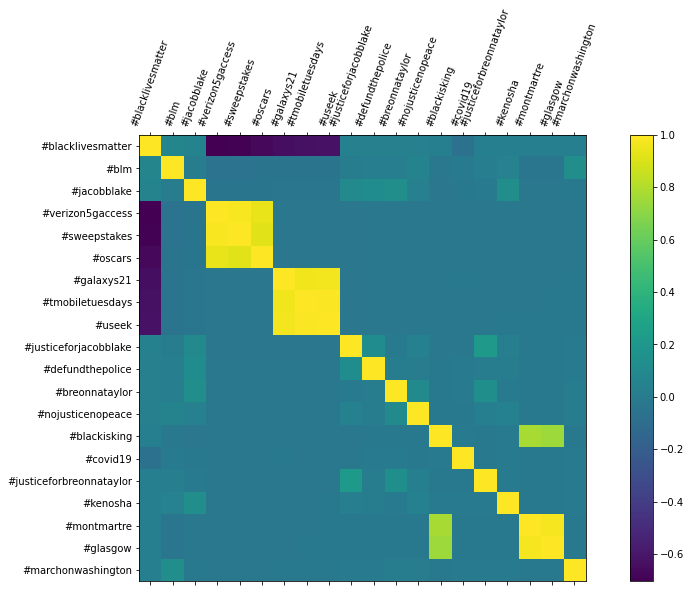

In [81]:
f = plt.figure(figsize=(16, 8))
plt.matshow(cor_matrix.corr(), fignum=f.number)
plt.xticks(range(cor_matrix.select_dtypes(['number']).shape[1]), cor_matrix.select_dtypes(['number']).columns, fontsize=10, rotation=70)
plt.yticks(range(cor_matrix.select_dtypes(['number']).shape[1]), cor_matrix.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
#plt.title('Correlation Matrix', fontsize=16);

In [85]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = cor_matrix.columns
    for i in range(0, cor_matrix.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n=5):
    au_corr = cor_matrix.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(cor_matrix)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]
get_top_abs_correlations(cor_matrix, 20)

#tmobiletuesdays       #useek                      0.990848
#verizon5gaccess       #sweepstakes                0.980635
#montmartre            #glasgow                    0.973687
#galaxys21             #useek                      0.972177
                       #tmobiletuesdays            0.963252
#verizon5gaccess       #oscars                     0.943657
#sweepstakes           #oscars                     0.924132
#blackisking           #montmartre                 0.776041
                       #glasgow                    0.751254
#blacklivesmatter      #verizon5gaccess            0.704725
                       #sweepstakes                0.697594
                       #oscars                     0.666330
                       #galaxys21                  0.639469
                       #tmobiletuesdays            0.627420
                       #useek                      0.621677
#justiceforjacobblake  #justiceforbreonnataylor    0.215858
#breonnataylor         #justiceforbreonn

In [86]:
from pandas import DataFrame
DataFrame(get_top_abs_correlations(cor_matrix, 20))

0
#tmobiletuesdays      #useek                    0.990848
#verizon5gaccess      #sweepstakes              0.980635
#montmartre           #glasgow                  0.973687
#galaxys21            #useek                    0.972177
                      #tmobiletuesdays          0.963252
#verizon5gaccess      #oscars                   0.943657
#sweepstakes          #oscars                   0.924132
#blackisking          #montmartre               0.776041
                      #glasgow                  0.751254
#blacklivesmatter     #verizon5gaccess          0.704725
                      #sweepstakes              0.697594
                      #oscars                   0.666330
                      #galaxys21                0.639469
                      #tmobiletuesdays          0.627420
                      #useek                    0.621677
#justiceforjacobblake #justiceforbreonnataylor  0.215858
#breonnataylor        #justiceforbreonnataylor  0.142162
#jacobblake           #breonnataylor            0.140017
                      #kenosha                  0.139443
#blm                  #marchonwashington        0.136755

In [ ]:
# =====================  DT algorithm =========================== #
#          use hashtag to predict topoic         #
# =================================================================== #

In [87]:
!pip install pydotplus
!pip install graphviz

In [107]:
class_names = ['T0','T1', 'T2', 'T3', 'T4','T5','T6']
feature_names = ['blacklivesmatter','#blm','#jacobblake','#verizon5gaccess', '#sweepstakes', '#oscars' , '#galaxys21', '#tmobiletuesdays', 
                 '#useek','#justiceforjacobblake', '#defundthepolice',  '#breonnataylor',   '#nojusticenopeace' , '#blackisking', 
                 '#covid19',  '#justiceforbreonnataylor', '#kenosha', '#montmartre',  '#glasgow',  '#marchonwashington']

In [108]:
X = matrix.drop(['Dominant_Topic'], axis=1)
y = matrix['Dominant_Topic']

In [109]:
# Decision tree model
# Decision Tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
#from sklearn.preprocessing import StandardScaler
#from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 100)

classifier = DecisionTreeClassifier()

parameters = {#'criterion':['entropy'],
              'max_depth': [2, 3, 5, 6, 8, 10], 
              'min_samples_split': [10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 8, 10, 30]            
             }

acc_scorer = make_scorer(accuracy_score)
#grid search
grid_obj = GridSearchCV(classifier, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf1 = grid_obj.best_estimator_

clf1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, min_samples_split=10)

In [110]:
# Model performance on training set
y_pred_train =clf1.predict(X_train)

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)
#print(classification_report(y_train, y_pred_train,target_names=class_names))

Accuracy: 0.90
Confusion Matrix: 
 [[    0     0    45     0     0     0     0]
 [    0     0    82     0     0     0     0]
 [    0     0 11826   124     0     0     0]
 [    0     0    56   237     0     0     0]
 [    0     0   613     4     0     0     0]
 [    0     0   133     0     0     0     0]
 [    0     0   222    42     0     0     0]]


In [111]:
q=classification_report(y_train, y_pred_train,target_names=class_names,output_dict=True) 
p = pd.DataFrame(q).transpose()
p

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
T0,0.000000,0.000000,0.000000,45.0000
T1,0.000000,0.000000,0.000000,82.0000
T2,0.911305,0.989623,0.948851,11950.0000
T3,0.582310,0.808874,0.677143,293.0000
T4,0.000000,0.000000,0.000000,617.0000
T5,0.000000,0.000000,0.000000,133.0000
T6,0.000000,0.000000,0.000000,264.0000
accuracy,0.901300,0.901300,0.901300,0.9013
macro avg,0.213373,0.256928,0.232285,13384.0000
weighted avg,0.826413,0.901300,0.862012,13384.0000


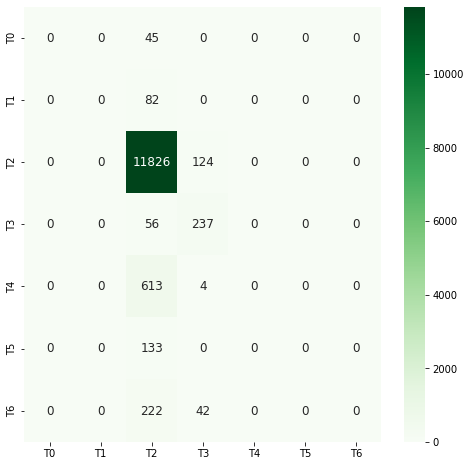

In [118]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, annot_kws={"size": 12},fmt='d',xticklabels=sorted(class_names), yticklabels = sorted(class_names),cmap="Greens")
#from google.colab import files
#plt.savefig("cm1.png")
#files.download("cm1.png")

In [120]:
# Predicting the test results
np.set_printoptions(threshold=np.inf)
y_pred=clf1.predict(X_test)

# Classification results on test set
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_pred,target_names=class_names))

Accuracy: 0.90
Confusion Matrix: 
 [[   0    0   11    0    0    0    0]
 [   0    0   20    0    0    0    0]
 [   0    0 2961   28    0    0    0]
 [   0    0   13   61    0    0    0]
 [   0    0  152    2    0    0    0]
 [   0    0   33    0    0    0    0]
 [   0    0   56   10    0    0    0]]
              precision    recall  f1-score   support

          T0       0.00      0.00      0.00        11
          T1       0.00      0.00      0.00        20
          T2       0.91      0.99      0.95      2989
          T3       0.60      0.82      0.70        74
          T4       0.00      0.00      0.00       154
          T5       0.00      0.00      0.00        33
          T6       0.00      0.00      0.00        66

    accuracy                           0.90      3347
   macro avg       0.22      0.26      0.24      3347
weighted avg       0.83      0.90      0.86      3347



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


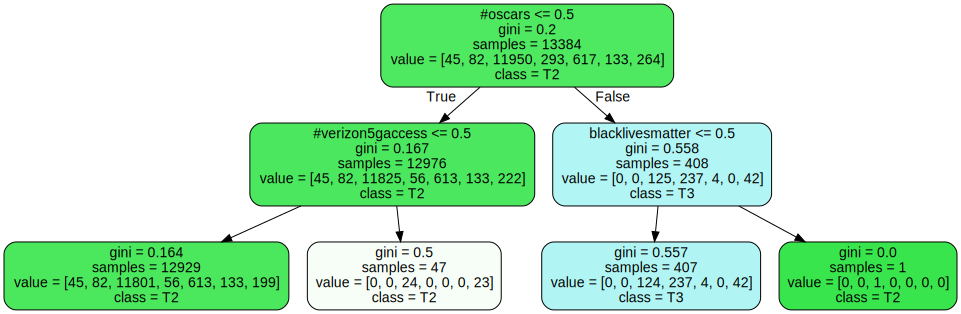

In [121]:
# Visualize the tree by graphiz
import graphviz
import pydotplus
from sklearn import tree
from google.colab import files

dot_data = tree.export_graphviz(clf1, out_file=None, filled=True, rounded = True,
                                feature_names=feature_names, class_names=class_names)
graph = graphviz.Source(dot_data)
graph
#graph = pydotplus.graph_from_dot_data(dot_data)
#graph.write_pdf('gdrive/My Drive/graph.pdf')
#graph.write_png('gdrive/My Drive/graph.png')

In [123]:
!pip install dtreeviz

     |████████████████████████████████| 61 kB 140 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.6-py3-none-any.whl size=67326 sha256=a6f8f2aa47033c631f79d6ce289881fdff5184b394f9da13d09e40bbb5f367ef
  Stored in directory: /root/.cache/pip/wheels/33/76/fe/99227ff871766e7284bb88d3d28e2f4886b8ec04d669033478
Successfully built dtreeviz


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atlea

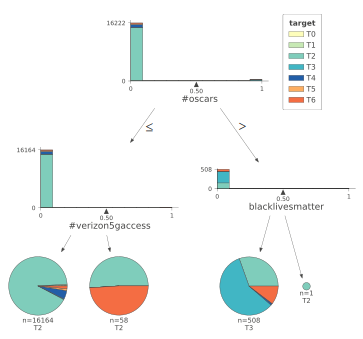

In [125]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(clf1, X, y,
                target_name="target",
                feature_names=feature_names, class_names=class_names)

viz